In [291]:
using Pkg; Pkg.activate(".")
using Revise
using PyPlot
import LinearAlgebra: norm

include("Opt.jl")
using .Opt

 Activating environment at `~/github/misc_impl/opt/Project.toml`


In [292]:
# pre-allocated
Γf = zeros(n_iterations, 3)

function access_state(state)
    Γf[state.k,:] = [state.x..., state.f]
end

Opt.GradientDescent(x0, rosenbrock, rosenbrock_grad!, 0.001;
    n_iterations = 1000,
    access_state = access_state)

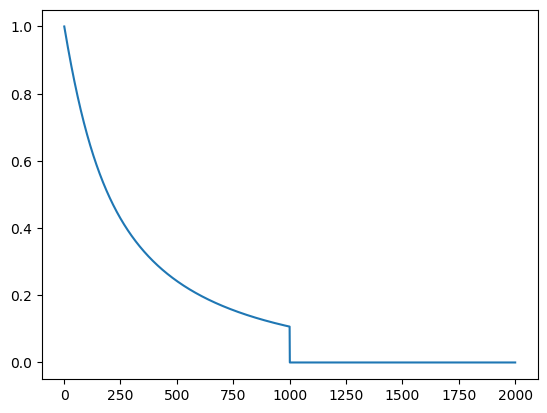

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1856a3c50>

In [293]:
plot(1:n_iterations, Γf[:,3])
# plot(1:n_iterations, )

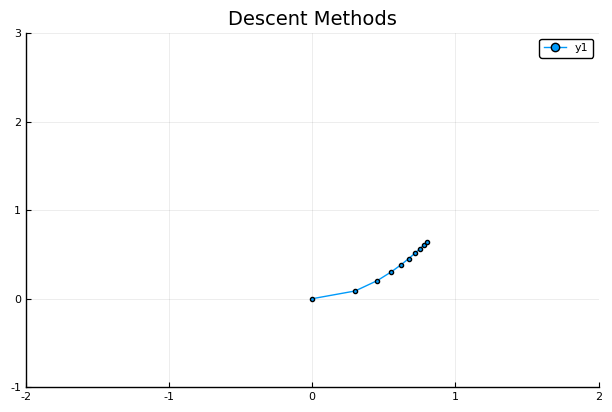

┌ Info: Saved animation to 
│   fn = /Users/wpq/github/misc_impl/opt/tmp.gif
└ @ Plots /Users/wpq/.julia/packages/Plots/vTdnV/src/animation.jl:98


Plots.AnimatedGif("/Users/wpq/github/misc_impl/opt/tmp.gif")
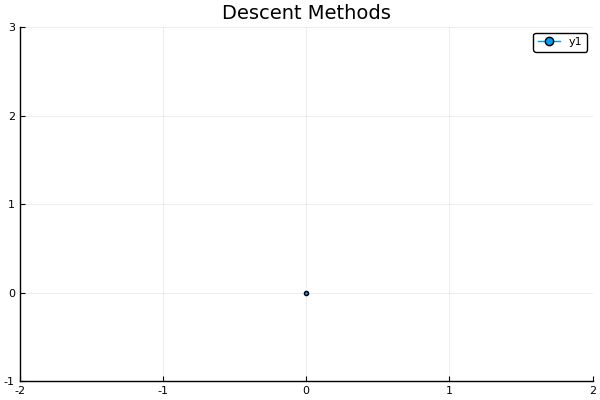

In [204]:
import Plots: @animate, plot3d, gif

step = 200
s = collect(1:step:n_iterations)
Γfs = Γf[s,:]


x = range(-2;stop=2,length=100)
y = range(-1;stop=3,length=100)
z = x .+ y

plt = Plots.plot(
    range(-2;stop=2,length=100),
    range(-1;stop=3,length=100),
    (x,y) -> rosenbrock([x y]),
    st=:contourf, camera=(-30,30))

plt = Plots.plot(
    1,
    xlim = (-2, 2),
    ylim = (-1, 3),
    zlim = (0, 2500),
    title = "Descent Methods",
    marker = 3)

anim = @animate for k=1:size(s, 1)
    push!(plt, Γfs[k,1], Γfs[k,2], Γfs[k])
end

Plots.gif(anim, "tmp.gif", fps = 15)

(100,)